# Train-and-Permute-CIFAR10-VGG11

This notebook executes the following:

1. We train two normalization-free, 2x width VGG11 networks, calling them model0 and model1.
2. We compute a set of permutations which align the neurons of model1 with those of model0. We use a correlation-based method which goes back to https://arxiv.org/abs/1511.07543.
3. We evaluate the accuracy of the interpolation between model0 and the neuron-permuted version of model1. It's not very good -- accuracy drops from ~90% at the "endpoint" networks to ~70% at the midpoint.
4. We investigate the cause of this drop. We find that the later hidden units of the interpolated network have "collapsed variance".
5. We introduce a method of correcting for this phenomenon: For each unit in the interpolated network, we rescale it such that its statistics are similar to those of the parent/endpoint networks.
6. We re-evaluate the interpolated network after this correction has been applied, and find that it gets 87% test accuracy. So the gap / "barrier" has shrunk from 90-70 = 20% to only 3%. The barrier in terms of test loss is also below 0.1 after correction.

We also note that the idea of resetting the BatchNorm statistics of interpolated networks goes at least back to https://arxiv.org/abs/1803.05407. The method we introduce here can be thought of as a generalization of BatchNorm-reset to networks which don't use BatchNorm!

For some comparable numbers we can look at the VGG curve of Figure 4 in Git Re-Basin (https://arxiv.org/abs/2209.04836). The authors use a permutation-only method with LayerNorm-based networks, and report a test loss barrier of ~0.25 for 2x-width VGG-16.

In [1]:
import os
import sys

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import torch
from torch import nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
import torchvision
import torchvision.transforms as T

# setup

In [2]:
## a directory to save VGG checkpoints
os.makedirs('./vgg', exist_ok=True)
def save_model(model, i):
    sd = model.state_dict()
    torch.save(model.state_dict(), 'vgg/%s.pt' % i)

def load_model(model, i):
    sd = torch.load('vgg/%s.pt' % i)
    model.load_state_dict(sd)

In [3]:
## CIFAR-10 dataloaders -- we use FFCV because it's fast
from ffcv.fields import IntField, RGBImageField
from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import RandomHorizontalFlip, Cutout, \
    RandomTranslate, Convert, ToDevice, ToTensor, ToTorchImage
from ffcv.transforms.common import Squeeze

CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]

## fast FFCV data loaders
device = 'cuda:0' 
label_pipeline = [IntDecoder(), ToTensor(), ToDevice(device), Squeeze()]
pre_p = [SimpleRGBImageDecoder()]
post_p = [
    ToTensor(),
    ToDevice(device, non_blocking=True),
    ToTorchImage(),
    Convert(torch.float16),
    T.Normalize(CIFAR_MEAN, CIFAR_STD),
]
aug_p = [
    RandomHorizontalFlip(),
    RandomTranslate(padding=4),
]


train_aug_loader = Loader(f'/tmp/cifar_train.beton',
                      batch_size=500,
                      num_workers=8,
                      order=OrderOption.RANDOM,
                      drop_last=True,
                      pipelines={'image': pre_p+aug_p+post_p,
                                 'label': label_pipeline})
train_noaug_loader = Loader(f'/tmp/cifar_train.beton',
                     batch_size=1000,
                     num_workers=8,
                     order=OrderOption.SEQUENTIAL,
                     drop_last=False,
                     pipelines={'image': pre_p+post_p,
                                'label': label_pipeline})
test_loader = Loader(f'/tmp/cifar_test.beton',
                     batch_size=1000,
                     num_workers=8,
                     order=OrderOption.SEQUENTIAL,
                     drop_last=False,
                     pipelines={'image': pre_p+post_p,
                                'label': label_pipeline})

In [4]:
## evaluation functions
# evaluates accuracy
def evaluate(model, loader=test_loader):
    model.eval()
    correct = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
    return correct

# evaluates acc and loss
def evaluate2(model, loader=test_loader):
    model.eval()
    losses = []
    correct = 0
    total = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            total += len(labels)
            loss = F.cross_entropy(outputs, labels.cuda())
            losses.append(loss.item())
    return correct / total, np.array(losses).mean()

def full_eval(model):
    tr_acc, tr_loss = evaluate2(model, loader=train_noaug_loader)
    te_acc, te_loss = evaluate2(model, loader=test_loader)
    return '%.2f, %.3f, %.2f, %.3f' % (100*tr_acc, tr_loss, 100*te_acc, te_loss)

## Train and save two models

In [5]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name, w=1, bn=False):
        super(VGG, self).__init__()
        self.vgg_name = vgg_name
        self.bn = bn
        self.w = w
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(self.w*512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers.append(nn.Conv2d(in_channels if in_channels == 3 else self.w*in_channels,
                                     self.w*x, kernel_size=3, padding=1))
                if self.bn:
                    layers.append(nn.BatchNorm2d(self.w*x))
                layers.append(nn.ReLU(inplace=True))
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [6]:
def train_model(w=1):
    model = VGG('VGG11', w=w).cuda()
    optimizer = SGD(model.parameters(), lr=0.08, momentum=0.9, weight_decay=5e-4)

    EPOCHS = 100
    ne_iters = len(train_aug_loader)
    lr_schedule = np.interp(np.arange(1+EPOCHS*ne_iters), [0, 5*ne_iters, EPOCHS*ne_iters], [0, 1, 0])
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_schedule.__getitem__)

    scaler = GradScaler()
    loss_fn = CrossEntropyLoss()

    losses = []
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        for i, (inputs, labels) in enumerate(train_aug_loader):
            optimizer.zero_grad(set_to_none=True)
            with autocast():
                outputs = model(inputs.cuda())
                loss = loss_fn(outputs, labels.cuda())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            losses.append(loss.item())
    return model

In [7]:
w = 2
model = train_model(w)
print(evaluate(model))
save_model(model, 'vgg11x%d_v1b' % w)

model = train_model(w)
print(evaluate(model))
save_model(model, 'vgg11x%d_v2b' % w)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:50<00:00,  2.31s/it]


9045


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:48<00:00,  2.29s/it]


9016


### matching code

In [8]:
# given two networks net0, net1 which each output a feature map of shape NxCxWxH
# this will reshape both outputs to (N*W*H)xC
# and then compute a CxC correlation matrix between the outputs of the two networks
def run_corr_matrix(net0, net1, epochs=1, norm=True, loader=train_aug_loader):
    n = epochs*len(loader)
    mean0 = mean1 = std0 = std1 = None
    with torch.no_grad():
        net0.eval()
        net1.eval()
        for _ in range(epochs):
            for i, (images, _) in enumerate(tqdm(loader)):
                img_t = images.float().cuda()
                out0 = net0(img_t)
                out0 = out0.reshape(out0.shape[0], out0.shape[1], -1).permute(0, 2, 1)
                out0 = out0.reshape(-1, out0.shape[2]).double()

                out1 = net1(img_t)
                out1 = out1.reshape(out1.shape[0], out1.shape[1], -1).permute(0, 2, 1)
                out1 = out1.reshape(-1, out1.shape[2]).double()

                mean0_b = out0.mean(dim=0)
                mean1_b = out1.mean(dim=0)
                std0_b = out0.std(dim=0)
                std1_b = out1.std(dim=0)
                outer_b = (out0.T @ out1) / out0.shape[0]

                if i == 0:
                    mean0 = torch.zeros_like(mean0_b)
                    mean1 = torch.zeros_like(mean1_b)
                    std0 = torch.zeros_like(std0_b)
                    std1 = torch.zeros_like(std1_b)
                    outer = torch.zeros_like(outer_b)
                mean0 += mean0_b / n
                mean1 += mean1_b / n
                std0 += std0_b / n
                std1 += std1_b / n
                outer += outer_b / n

    cov = outer - torch.outer(mean0, mean1)
    if norm:
        corr = cov / (torch.outer(std0, std1) + 1e-4)
        return corr
    else:
        return cov

In [9]:
def get_layer_perm1(corr_mtx):
    corr_mtx_a = corr_mtx.cpu().numpy()
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(corr_mtx_a, maximize=True)
    assert (row_ind == np.arange(len(corr_mtx_a))).all()
    perm_map = torch.tensor(col_ind).long()
    return perm_map

# returns the channel-permutation to make layer1's activations most closely
# match layer0's.
def get_layer_perm(net0, net1):
    corr_mtx = run_corr_matrix(net0, net1)
    return get_layer_perm1(corr_mtx)

In [10]:
# modifies the weight matrices of a convolution and batchnorm
# layer given a permutation of the output channels
def permute_output(perm_map, conv, bn):
    pre_weights = [
        conv.weight,
    ]
    if conv.bias is not None:
        pre_weights.append(conv.bias)
    if bn is not None:
        pre_weights.extend([
            bn.weight,
            bn.bias,
            bn.running_mean,
            bn.running_var,
        ])
    for w in pre_weights:
        w.data = w[perm_map]

# modifies the weight matrix of a layer for a given permutation of the input channels
# works for both conv2d and linear
def permute_input(perm_map, layer):
    w = layer.weight
    w.data = w[:, perm_map]

# Find neuron-permutation for each layer

In [11]:
model0 = VGG('VGG11', w=w).cuda()
model1 = VGG('VGG11', w=w).cuda()
load_model(model0, 'vgg11x%d_v1b' % w)
load_model(model1, 'vgg11x%d_v2b' % w)

evaluate(model0), evaluate(model1)

(9045, 9016)

## Permuting neurons in model1 to match model0

In [12]:
def subnet(model, n_layers):
    return model.features[:n_layers]

feats1 = model1.features

n = len(feats1)
for i in range(n):
    layer = feats1[i]
    if isinstance(layer, nn.Conv2d):
        # get permutation and permute output of conv and maybe bn
        if isinstance(feats1[i+1], nn.BatchNorm2d):
            assert isinstance(feats1[i+2], nn.ReLU)
            perm_map = get_layer_perm(subnet(model0, i+3), subnet(model1, i+3))
            permute_output(perm_map, feats1[i], feats1[i+1])
        else:
            assert isinstance(feats1[i+1], nn.ReLU)
            perm_map = get_layer_perm(subnet(model0, i+2), subnet(model1, i+2))
            permute_output(perm_map, feats1[i], None)
        # look for succeeding layer to permute input
        next_layer = None
        for j in range(i+1, n):
            if isinstance(feats1[j], nn.Conv2d):
                next_layer = feats1[j]
                break
        if next_layer is None:
            next_layer = model1.classifier
        permute_input(perm_map, next_layer)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.65it/s]


### Save permuted weights

In [13]:
# ensure accuracy didn't change
# (it may be slightly different due to non-associativity of floating point arithmetic)
print(evaluate(model1))
save_model(model1, 'vgg11x%d_v2b_perm1b' % w)

9015


## Evaluate the interpolated network

In [14]:
def mix_weights(model, alpha, key0, key1):
    sd0 = torch.load('vgg/%s.pt' % key0)
    sd1 = torch.load('vgg/%s.pt' % key1)
    sd_alpha = {k: (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
                for k in sd0.keys()}
    model.load_state_dict(sd_alpha)

# use the train loader with data augmentation as this gives better results
def reset_bn_stats(model, epochs=1, loader=train_aug_loader):
    # resetting stats to baseline first as below is necessary for stability
    for m in model.modules():
        if type(m) == nn.BatchNorm2d:
            m.momentum = None # use simple average
            m.reset_running_stats()
    # run a single train epoch with augmentations to recalc stats
    model.train()
    for _ in range(epochs):
        with torch.no_grad(), autocast():
            for images, _ in loader:
                output = model(images.cuda())

In [15]:
model_a = VGG('VGG11', w=w).cuda()
mix_weights(model_a, 0.5, 'vgg11x%d_v1b' % w, 'vgg11x%d_v2b_perm1b' % w)
print(full_eval(model_a))

77.59, 0.815, 73.12, 0.904


## Diagnosing the problem: measuring unitwise variances

The interpolated network got 70% train accuracy -- not very good, much worse than the endpoints which get over 90%. Why does this happen?

(We find that) in later layers of the interpolated network, the variance of hidden units has "collapsed", relative to the variance of the same hidden units in the original/parent/endpoint networks.

In [16]:
inputs, _ = next(iter(train_aug_loader))

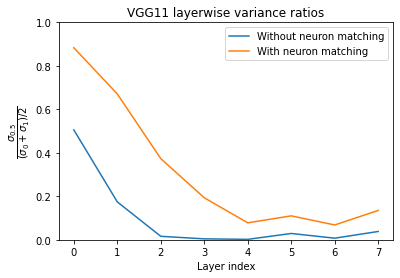

In [17]:
# returns (vv0, vva, vv1)
# where vv0 is a list of layerwise variances (as defined in paper)
# for model0 (alpha=0.0)
# and vva is the same for the midpoint (alpha=0.5)
# and vv1 for model1 (alpha=1.0)
def get_layerwise_vars(k0, k1):
    vvs = []
    for alpha in [0, 0.5, 1]:
        mix_weights(model_a, alpha, k0, k1)
        vv = []
        for i in [1, 4, 7, 9, 12, 14, 17, 19]:
#         for i in [2, 5, 8, 10, 13, 15, 18, 20]:
            subnet = model_a.features[:i]
            with torch.no_grad(), autocast():
                out = subnet(inputs)
            out = out.permute(1, 0, 2, 3).reshape(out.size(1), -1)
            avg_var = out.var(1).mean()
            vv.append(avg_var.item())
        vvs.append(np.array(vv))
    vv0, vva, vv1 = vvs
    return vv0, vva, vv1

# returns a list of ratios between the variance of
# the weight-interpolation midpoint and the averaged variances
# of the two endpoints.
def get_layerwise_ratios(k0, k1):
    vv0, vva, vv1 = get_layerwise_vars(k0, k1)
    vv00 = (vv0+vv1)/2
    rr = vva/vv0
    return rr

k0 = 'vgg11x%d_nobn_v1' % w
k1 = 'vgg11x%d_nobn_v2' % w
rr1 = get_layerwise_ratios(k0, k1)

k0 = 'vgg11x%d_nobn_v1' % w
k1 = 'vgg11x%d_nobn_v2_perm1' % w
rr2 = get_layerwise_ratios(k0, k1)

plt.plot(rr1, label='Without neuron matching')
plt.plot(rr2, label='With neuron matching')
# plt.yscale('log')
plt.ylim([0, 1])
plt.xlabel('Layer index')
plt.title('VGG11 layerwise variance ratios')
plt.ylabel('$\\dfrac{\\sigma_{0.5}}{(\\sigma_0 + \\sigma_1)/2}$')
plt.legend()
plt.show()

## Solving the problem: Activation Renormalization

We introduce a rescaling of each neuron's preactivation in the interpolated network, such that the statistics of each neuron are set to be similar to those of the endpoint networks. Practically, this is accomplished by the temporary introduction of PyTorch nn.BatchNorm2d layers, which are then "fused" back into the preceding convolutions.

In [18]:
class ResetConv(nn.Module):
    def __init__(self, conv):
        super().__init__()
        self.h = h = conv.out_channels
        self.conv = conv
        self.bn = nn.BatchNorm2d(h)
        self.rescale = False
        
    def set_stats(self, goal_mean, goal_var):
        self.bn.bias.data = goal_mean
        goal_std = (goal_var + 1e-5).sqrt()
        self.bn.weight.data = goal_std
        
    def forward(self, x):
        x = self.conv(x)
        if self.rescale:
            x = self.bn(x)
        else:
            self.bn(x)
        return x

def make_tracked_net(net, w):
    net1 = VGG('VGG11', w=w).cuda()
    net1.load_state_dict(net.state_dict())
    feats1 = net1.features
    for i, layer in enumerate(feats1):
        if isinstance(layer, nn.Conv2d):
            feats1[i] = ResetConv(layer)
    return net1.cuda().eval()

def fuse_conv_bn(conv, bn):
    fused = torch.nn.Conv2d(
        conv.in_channels,
        conv.out_channels,
        kernel_size=conv.kernel_size,
        stride=conv.stride,
        padding=conv.padding,
        bias=True,
    )

    # setting weights
    w_conv = conv.weight.clone()
    bn_std = (bn.eps + bn.running_var).sqrt()
    gamma = bn.weight / bn_std
    fused.weight.data = (w_conv * gamma.reshape(-1, 1, 1, 1))

    # setting bias
    b_conv = conv.bias if conv.bias is not None else torch.zeros_like(bn.bias)
    beta = bn.bias + gamma * (-bn.running_mean + b_conv)
    fused.bias.data = beta
    
    return fused

def fuse_tracked_net(net, w):
    net1 = VGG('VGG11', w=w).cuda()
    feats1 = net1.features
    for i, layer in enumerate(net.features):
        if isinstance(layer, ResetConv):
            conv = fuse_conv_bn(layer.conv, layer.bn)
            feats1[i].load_state_dict(conv.state_dict())
    net1.classifier.load_state_dict(net.classifier.state_dict())
    return net1

In [19]:
model0 = VGG('VGG11', w).cuda()
model_a = VGG('VGG11', w).cuda()
model1 = VGG('VGG11', w).cuda()

k0 = 'vgg11x%d_nobn_v1' % w
k1 = 'vgg11x%d_nobn_v2_perm1' % w
mix_weights(model0, 0.0, k0, k1)
mix_weights(model_a, 0.5, k0, k1)
mix_weights(model1, 1.0, k0, k1)

print('train_acc, train_loss, test_acc, test_loss...')
print('(α=0.0)', full_eval(model0))
print('(α=0.5)', full_eval(model_a))
print('(α=1.0)', full_eval(model1))

train_acc, train_loss, test_acc, test_loss...
(α=0.0) 99.98, 0.002, 90.43, 0.451
(α=0.5) 73.66, 0.744, 69.57, 0.858
(α=1.0) 99.99, 0.002, 90.30, 0.439


In [20]:
## calculate the statistics of every hidden unit in the endpoint networks
## this is done practically using PyTorch BatchNorm2d layers.
wrap0 = make_tracked_net(model0, w=w)
wrap1 = make_tracked_net(model1, w=w)
reset_bn_stats(wrap0)
reset_bn_stats(wrap1)

wrap_a = make_tracked_net(model_a, w=w)
## set the goal mean/std in added bns of interpolated network, and turn batch renormalization on
for m0, m_a, m1 in zip(wrap0.modules(), wrap_a.modules(), wrap1.modules()):
    if not isinstance(m0, ResetConv):
        continue
    # get goal statistics -- interpolate the mean and std of parent networks
    mu0 = m0.bn.running_mean
    mu1 = m1.bn.running_mean
    goal_mean = (mu0 + mu1)/2
    var0 = m0.bn.running_var
    var1 = m1.bn.running_var
    goal_var = ((var0.sqrt() + var1.sqrt())/2).square()
    # set these in the interpolated bn controller
    m_a.set_stats(goal_mean, goal_var)
    # turn rescaling on
    m_a.rescale = True
    
# reset the tracked mean/var and fuse rescalings back into conv layers 
reset_bn_stats(wrap_a)
# fuse the rescaling+shift coefficients back into conv layers
model_b = fuse_tracked_net(wrap_a, w)

In [21]:
print('(α=0.5 corrected)', full_eval(model_b))

(α=0.5 corrected) 94.82, 0.156, 87.08, 0.539
